In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date, datetime, timedelta

pd.plotting.register_matplotlib_converters()

In [83]:
from eensight.preprocessing.utils import fit_pdf
from eensight.prediction import seasonal_predict
from eensight.preprocessing import (validate_data, global_filter, global_outlier_detect, 
                                    local_outlier_detect, check_column_values_not_null)


### Select a dataset from the demo catalog

In [9]:
data = pd.read_csv('../data/01_raw/demo_site_01/train/consumption.csv')

### Make sure that the data is in the appropriate format

In [10]:
data = validate_data(data, 'consumption', 'timestamp')

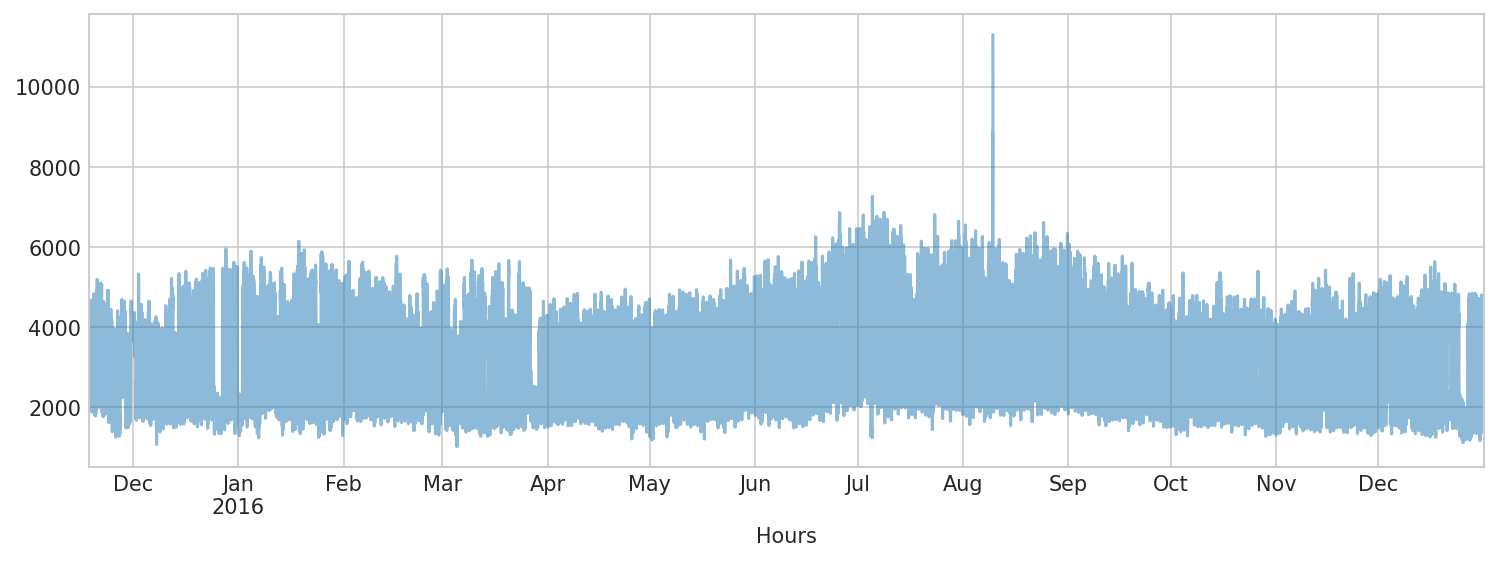

In [11]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 4), dpi=150)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    data['consumption'].plot(ax=ax, alpha=0.5)
    ax.set_xlabel('Hours')

### Identify potential outliers

**Global filter**: The first step screens for non-physically plausible values as well as unlikely values in the data. For power consumption data, negative and zero values are filtered out. For both consumption and temperature data, values that are at least 10 times larger than the median value are also removed. The threshold of ten times the median value aims at removing the most extreme outliers. Furthermore, long streaks of constant values are filtered out as well (here *long* is defined in hours by `no_change_window`).

In [12]:
data['consumption'] = global_filter(data['consumption'], no_change_window=4,
                                    allow_zero=False, allow_negative=False)

Seasonality leads to multimodal distributions. As a result, methods that rely on the assumption that data follows a Normal distribution – such as simple three-sigma rules, the Grubbs test or the Extreme Studentized Deviate (ESD) test – should be used only after a seasonal filter has been applied to the data

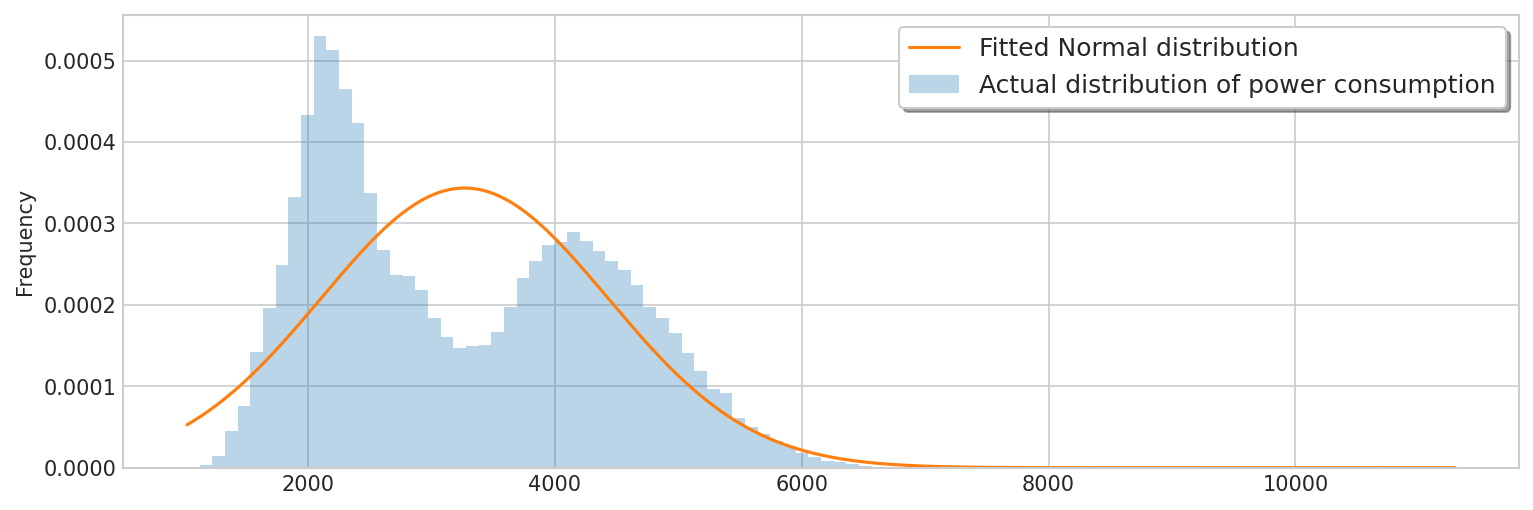

In [13]:
consumption = data['consumption'].dropna().values
x_d = np.linspace(consumption.min(), consumption.max(), 2000)
params, pdf = fit_pdf(x_d, consumption)

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 4), dpi=150)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    data['consumption'].plot(kind='hist', bins=100, density=True, alpha=0.3, ax=ax)
    pd.Series(pdf, x_d).plot(ax=ax)
    
    ax.legend(['Fitted Normal distribution', 'Actual distribution of power consumption'], 
              frameon=True, shadow=True, fontsize=12)

In [16]:
pred, model = seasonal_predict(data, target_name='consumption')

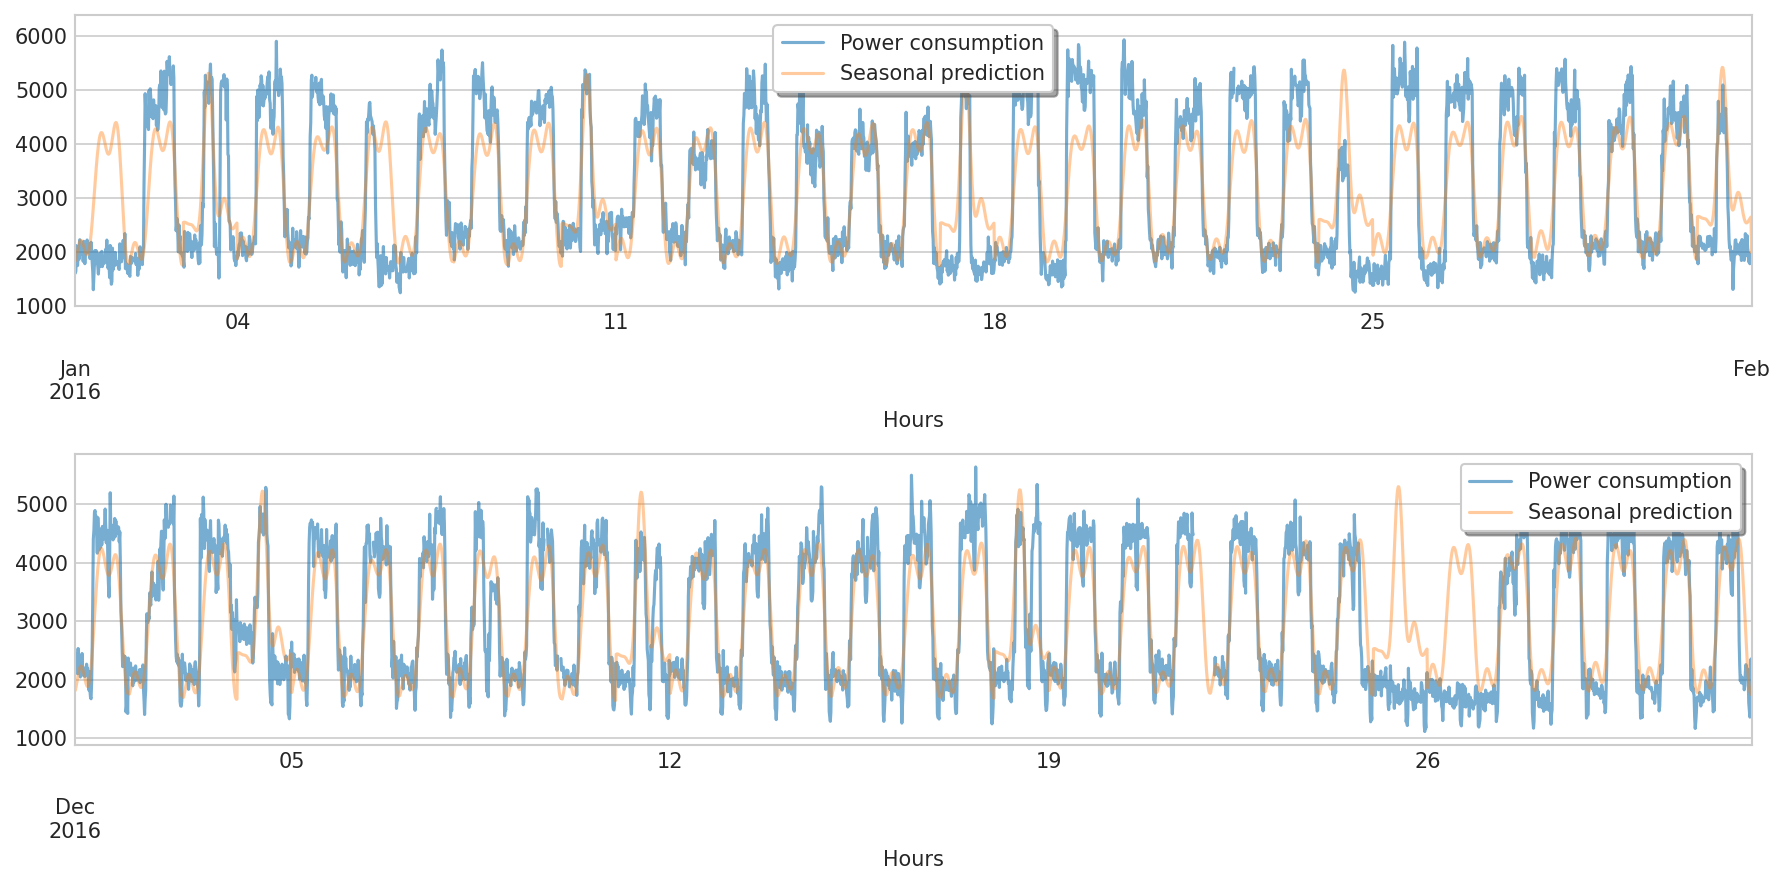

In [17]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 6), dpi=150)
    layout = (2, 1)
    ax1 = plt.subplot2grid(layout, (0, 0))
    ax2 = plt.subplot2grid(layout, (1, 0))

    start = datetime(2016, 1, 1, 0)
    end = datetime(2016, 2, 1, 0)
    data['consumption'].loc[start:end].plot(ax=ax1, alpha=0.6)
    pred.loc[start:end].plot(ax=ax1, alpha=0.4)
    ax1.set_xlabel('Hours')
    ax1.legend(['Power consumption', 'Seasonal prediction'], frameon=True, shadow=True)
    
    start = datetime(2016, 12, 1, 0)
    end = datetime(2017, 1, 1, 0)
    data['consumption'].loc[start:end].plot(ax=ax2, alpha=0.6)
    pred.loc[start:end].plot(ax=ax2, alpha=0.4)
    ax2.set_xlabel('Hours')
    ax2.legend(['Power consumption', 'Seasonal prediction'], frameon=True, shadow=True)

fig.tight_layout()

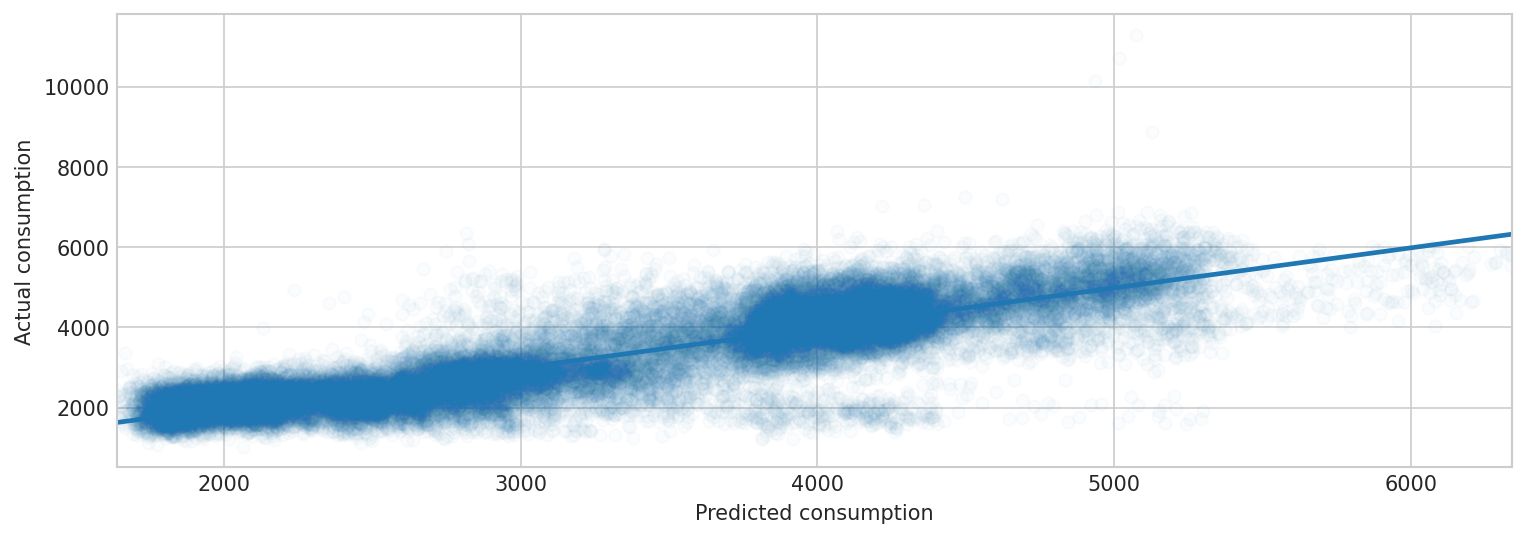

In [18]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 4), dpi=150)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    sns.regplot(x=pred, y=data['consumption'], ax=ax, scatter_kws=dict(alpha=0.02))
    ax.set_xlabel('Predicted consumption')
    ax.set_ylabel('Actual consumption')

In [19]:
residuals = data['consumption'] - pred['consumption_pred']

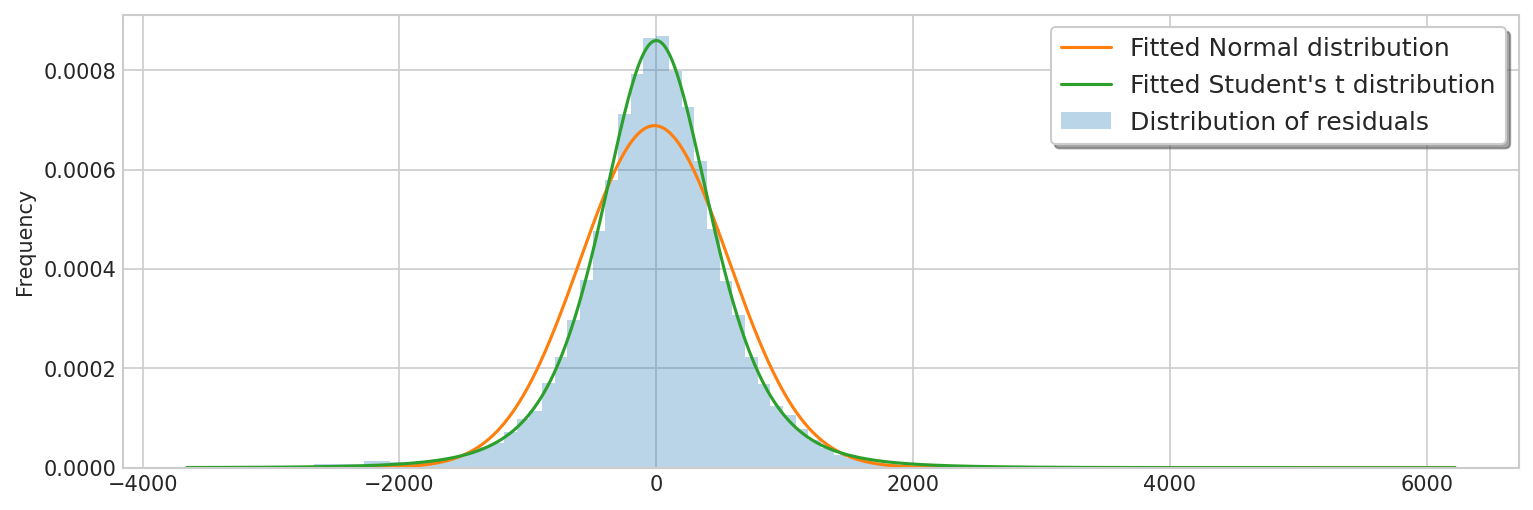

In [20]:
import scipy.stats as stats

residuals_ = residuals.dropna().values
x_d = np.linspace(residuals_.min(), residuals_.max(), 2000)

_, pdf_normal = fit_pdf(x_d, residuals_)
_, pdf_t = fit_pdf(x_d, residuals_, distribution=stats.t)


with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 4), dpi=150)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    residuals.plot(kind='hist', bins=100, density=True, alpha=0.3, ax=ax)
    pd.Series(pdf_normal, x_d).plot(ax=ax)
    pd.Series(pdf_t, x_d).plot(ax=ax)
    
    ax.legend(['Fitted Normal distribution', 'Fitted Student\'s t distribution',
               'Distribution of residuals'], 
              frameon=True, shadow=True, fontsize=12)

In [22]:
outliers_global = global_outlier_detect(residuals)

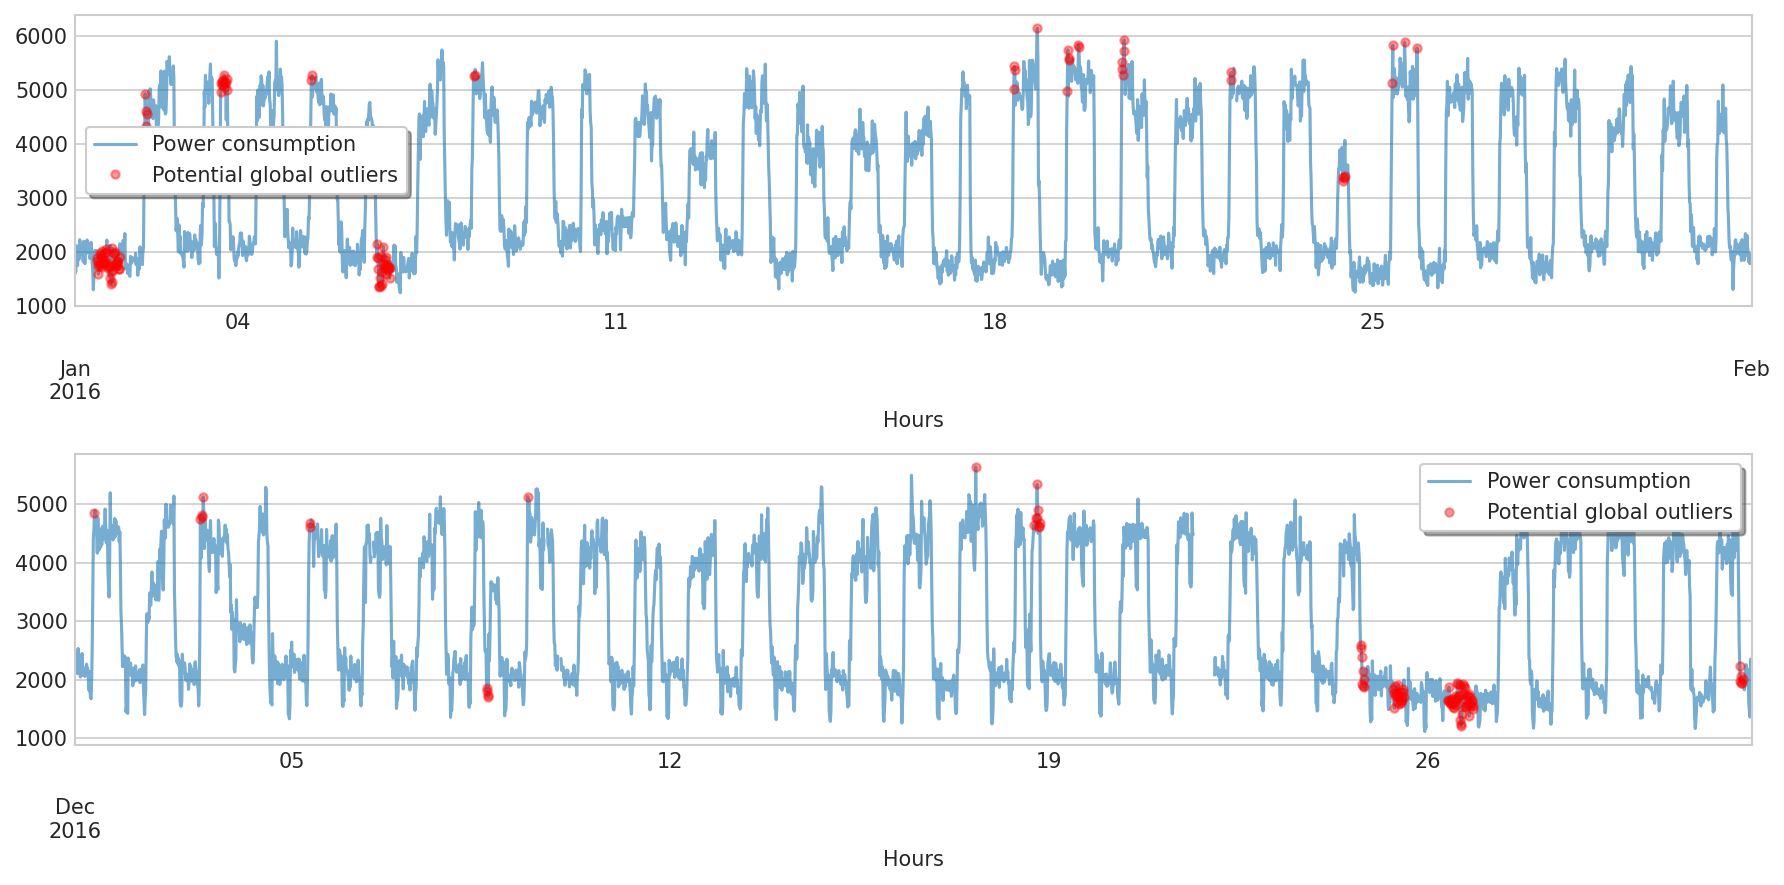

In [23]:
subset = data.loc[data.index.isin(outliers_global[outliers_global].index), 'consumption']

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 6), dpi=150)
    layout = (2, 1)
    ax1 = plt.subplot2grid(layout, (0, 0))
    ax2 = plt.subplot2grid(layout, (1, 0))
    
    start = datetime(2016, 1, 1, 0)
    end = datetime(2016, 2, 1, 0)
    data['consumption'].loc[start:end].plot(ax=ax1, alpha=0.6)
    subset.loc[start:end].plot(ax=ax1, style='o', ms=4, c='red', alpha=0.4)
    ax1.set_xlabel('Hours')
    ax1.legend(['Power consumption', 'Potential global outliers'], frameon=True, shadow=True)
    
    start = datetime(2016, 12, 1, 0)
    end = datetime(2017, 1, 1, 0)
    data['consumption'].loc[start:end].plot(ax=ax2, alpha=0.6)
    subset.loc[start:end].plot(ax=ax2, style='o', ms=4, c='red', alpha=0.4)
    ax2.set_xlabel('Hours')
    ax2.legend(['Power consumption', 'Potential global outliers'], frameon=True, shadow=True)
    
fig.tight_layout()

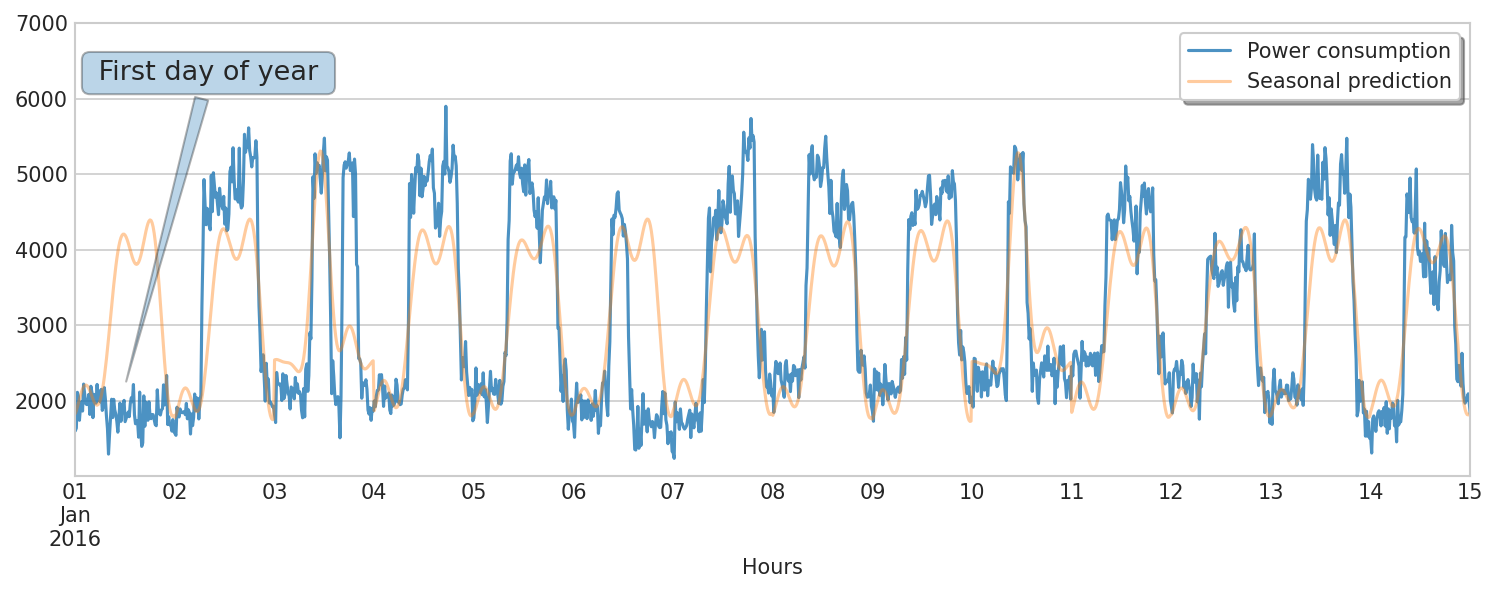

In [25]:
start = datetime(2016, 1, 1, 0)
end = datetime(2016, 1, 1, 0) + timedelta(days=14)

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 4), dpi=150)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    data['consumption'].loc[start:end].plot(ax=ax, alpha=0.8)
    pred.loc[start:end].plot(ax=ax, alpha=0.4)
    
    ax.set_ylim(top=7000)
    ax.annotate(' First day of year ', xy=(datetime(2016, 1, 1, 12), 2200),  xycoords='data',
             xytext=(40, 150), textcoords='offset points',
             size=13, ha='center', va="center",
             bbox=dict(boxstyle="round", alpha=0.3),
             arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.3))
    
    ax.set_xlabel('Hours')
    ax.legend(['Power consumption', 'Seasonal prediction'], frameon=True, shadow=True)

In [70]:
outliers_local = local_outlier_detect(residuals)

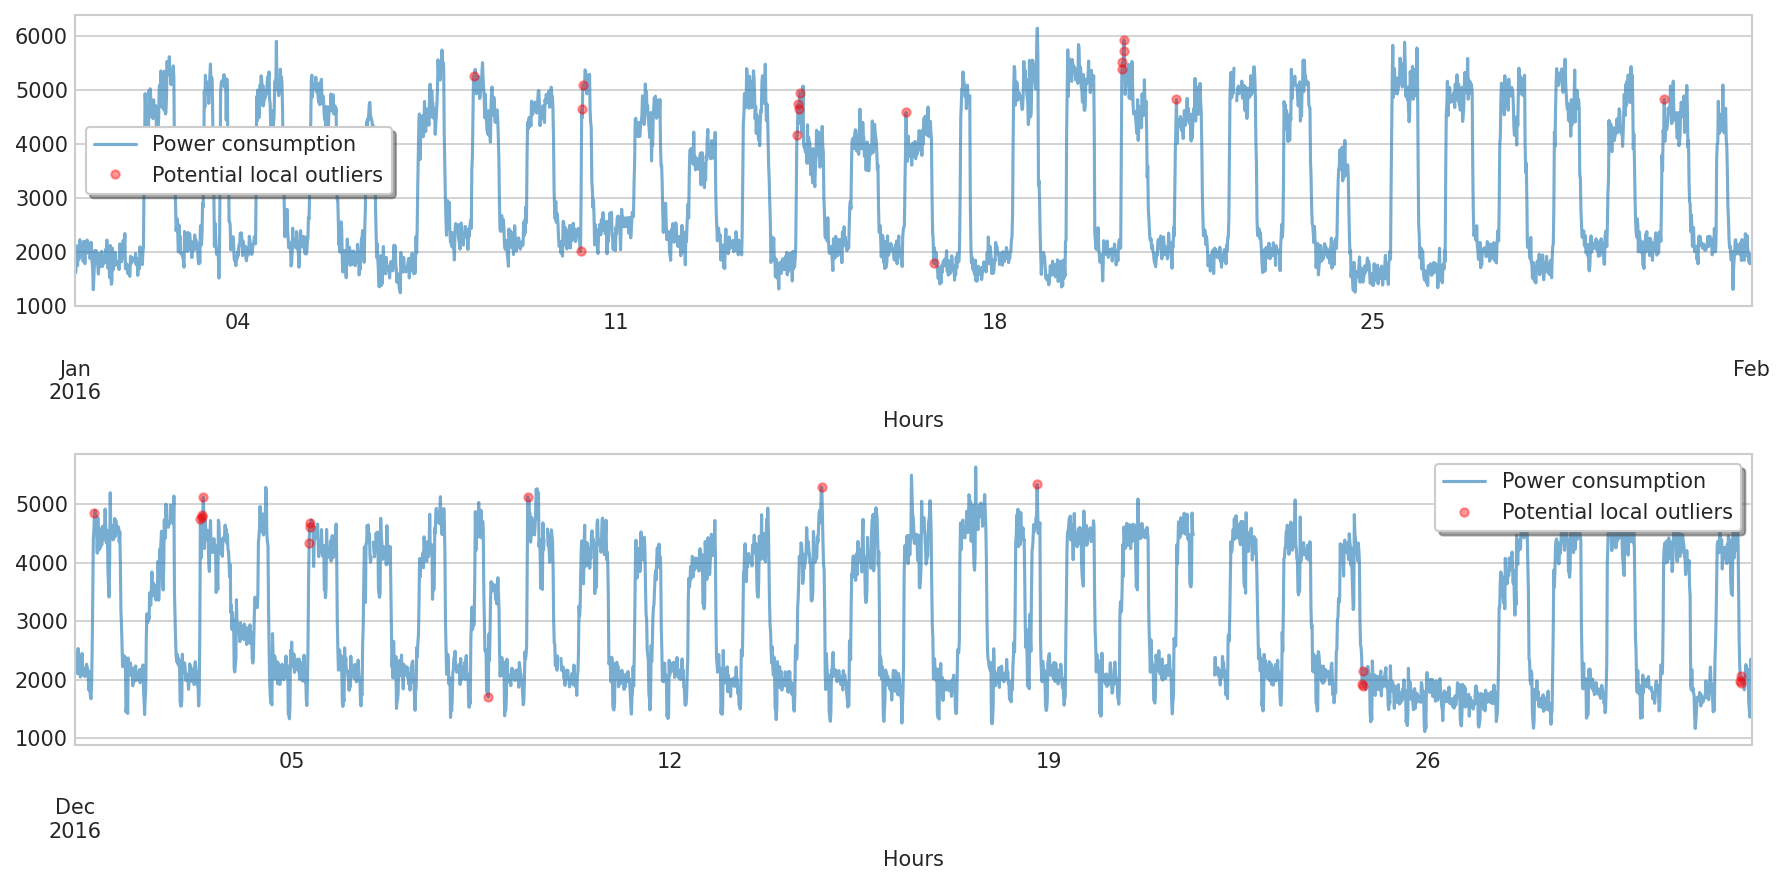

In [73]:
subset = data.loc[data.index.isin(outliers_local[outliers_local].index), 'consumption']

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 6), dpi=150)
    layout = (2, 1)
    ax1 = plt.subplot2grid(layout, (0, 0))
    ax2 = plt.subplot2grid(layout, (1, 0))
    
    start = datetime(2016, 1, 1, 0)
    end = datetime(2016, 2, 1, 0)
    data['consumption'].loc[start:end].plot(ax=ax1, alpha=0.6)
    subset.loc[start:end].plot(ax=ax1, style='o', ms=4, c='red', alpha=0.4)
    ax1.set_xlabel('Hours')
    ax1.legend(['Power consumption', 'Potential local outliers'], frameon=True, shadow=True)
    
    start = datetime(2016, 12, 1, 0)
    end = datetime(2017, 1, 1, 0)
    data['consumption'].loc[start:end].plot(ax=ax2, alpha=0.6)
    subset.loc[start:end].plot(ax=ax2, style='o', ms=4, c='red', alpha=0.4)
    ax2.set_xlabel('Hours')
    ax2.legend(['Power consumption', 'Potential local outliers'], frameon=True, shadow=True)
    
fig.tight_layout()

In [74]:
outliers = np.logical_and(outliers_global, outliers_local)

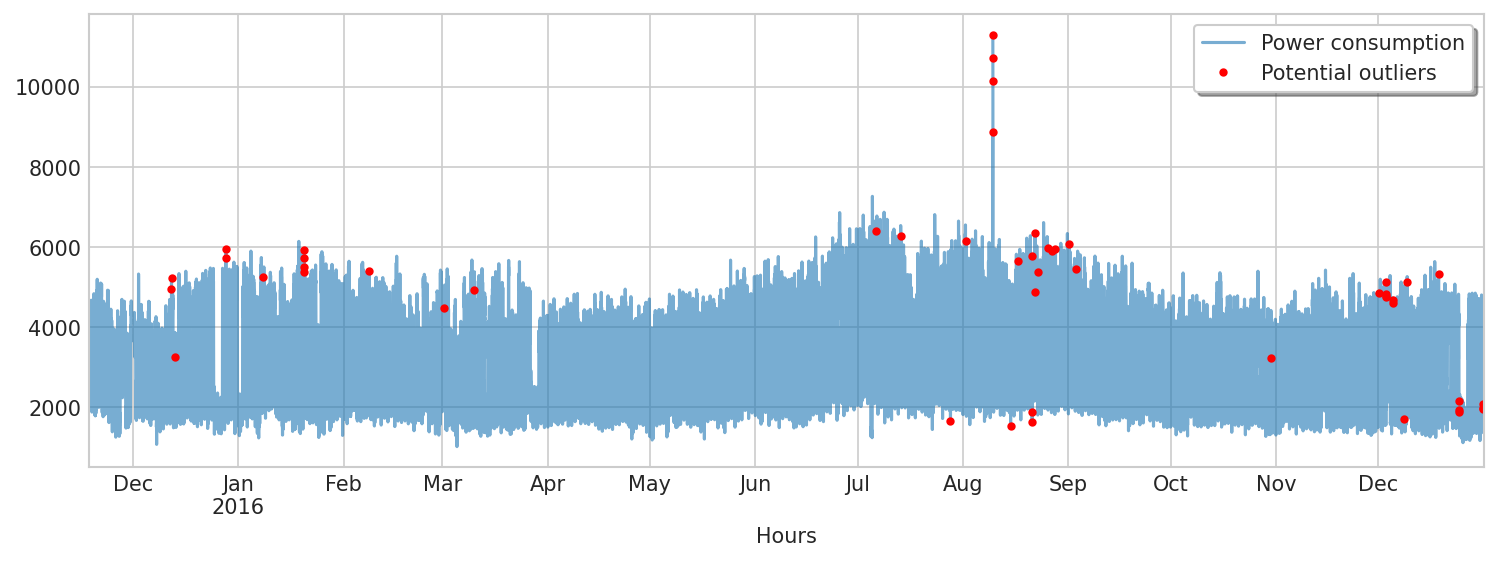

In [77]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 4), dpi=150)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    data['consumption'].plot(ax=ax, alpha=0.6)
    
    subset = data.loc[data.index.isin(outliers[outliers==True].index), 'consumption']
    subset.plot(ax=ax, style='o', ms=3, c='red')
    
    ax.set_xlabel('Hours')
    ax.legend(['Power consumption', 'Potential outliers'], frameon=True, shadow=True)

In [81]:
data['consumption_outlier'] = False 
data.loc[outliers[outliers==True].index, 'consumption_outlier'] = True

### Ensure enough training data

In [85]:
avail_data = dict()

for month_year, group in data.groupby([lambda x: x.year, lambda x: x.month]):
    group = group[~group['consumption_outlier']]
    check = check_column_values_not_null(group, 'consumption', mostly=0.9)
    avail_data[month_year] = check.result['unexpected_percent']

avail_data = {f'{key[0]}M{key[1]}' :val for key, val in avail_data.items()}
avail_data = pd.DataFrame.from_dict(avail_data, orient='index', columns=['values'])

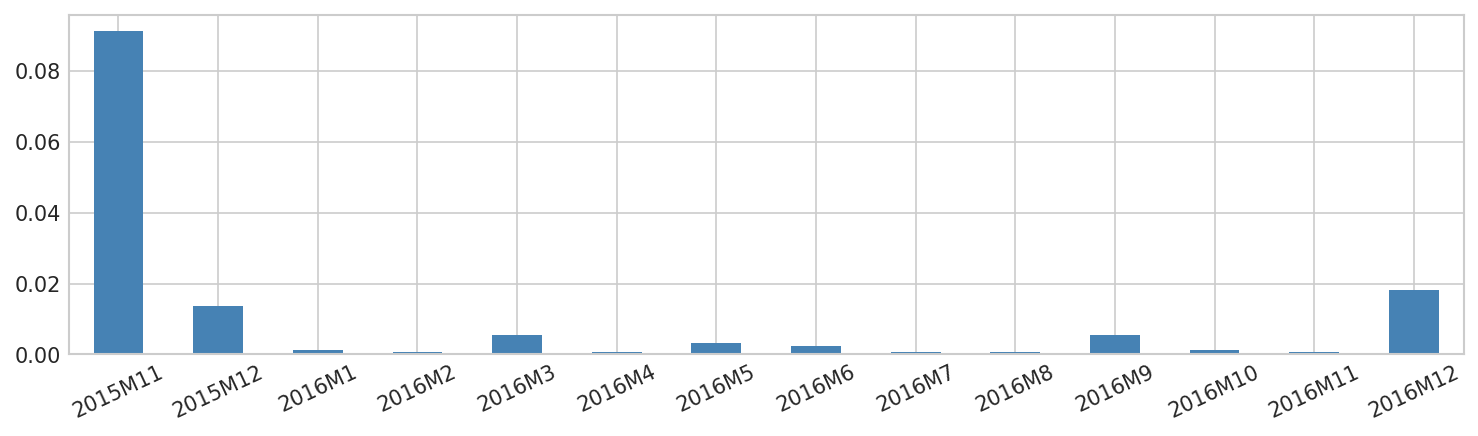

In [87]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3), dpi=150)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    subset = avail_data[avail_data['values'] > 0.1]
    if len(subset) > 0:
        subset.plot.bar(rot=25, ax=ax, color='#C71585', legend=False)
    
    subset = avail_data[avail_data['values'] <= 0.1]
    if len(subset) > 0:
        subset.plot.bar(rot=25, ax=ax, color='#4682B4', legend=False)


### Impute outliers and missing values

In [88]:
data['consumption'] = data['consumption'].mask(data['consumption_outlier'], other=np.nan)
data = data.drop('consumption_outlier', axis=1)

In [89]:
print('Number of missing consumption values before: {}'
          .format(data['consumption'].isna().sum())
)

Number of missing consumption values before: 327


In [92]:
data['consumption_imputed'] = False

data['consumption_imputed'] = (
        data['consumption_imputed'].mask(data['consumption'].isna(), other=True)
)

data['consumption'] = (
        data['consumption'].mask(data['consumption_imputed'], other=pred['consumption_pred'])
) 

In [93]:
print('Number of missing consumption values after: {}'
          .format(data['consumption'].isna().sum())
)

Number of missing consumption values after: 0


In [95]:
data.to_csv('../data/02_intermediate/demo_site_01/train/consumption.csv')